

## **Sobre o Dataset:**

O dataset utilizado nesta análise é uma base de dados contendo registros de oportunidades de emprego do sistema Jerimum Jobs. Esse dataset contém, ao todo: 947 registros (linhas) com as seguintes categorias de dados (colunas):
* Empresa (nome da empresa resposável);
* Vaga (título da vaga);
* Data de abertura (data de cadastro na vaga no sistema);
* Data de validade (data máxima que a vaga estará no sistema);
* Salário (valor do salário para a vaga);
* Regime (tipo de regime: Bolsa, CLT ou PJ);
* Área de atuação (uma lista de áreas em que a vaga se enquadra, dentre: 'Design/UX', 'Desenvolvimento', 'Gestão', 'Organizacional', 'Segurança', 'DevOps', 'Financeiro', 'Banco de Dados', 'Marketing', 'Testes', 'Infraestrutura/Redes').


---



## **Representação da rede:**

As redes geradas a partir do dataset são três grafos que relacionam as informações obtidas a partir dos registros da base de dados para criar nós (vértices) e implementar relações entre esses nós (arestas). A seguir uma descrição de como isso foi feito em cada um dos grafos gerados:
* **GRAFO DE EMPRESAS**:
  * VÉRTICE: Representa a vaga cadastrada
  * ARESTA: Representa a relação de pertencer à mesma empresa, de modo que, dois vértices (duas vagas) quaisquer estarão ligados por uma aresta se pertencerem a uma mesma empresa.

* **GRAFO DE ÁREAS DE ATUAÇÃO**:
  * VÉRTICE: Representa a vaga cadastrada
  * ARESTA: Representa a relação de se enquadrar em uma mesma área de atuação, de modo que, dois vértices (duas vagas) quaisquer estarão ligados por uma aresta se tiverem, pelo menos, um dos items de sua lista de áreas de atuação igual.

* **GRAFO DE TIPO DE REGIME**:
  * VÉRTICE: Representa a vaga cadastrada
  * ARESTA: Representa a relação ter o mesmo tipo de regime de trabalho, de modo que, dois vértices (duas vagas) quaisquer estarão ligados por uma aresta se possuírem regimes de trabalho iguais.

## Instalação das bibliotecas: NetworkX, Pyvis, Streamlit

In [1]:
!pip install networkx pyvis==0.1.9 streamlit

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


## Importação de Bibliotecas necessárias:

In [2]:
import random
import unicodedata
import networkx as nx
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
from itertools import combinations
from pyvis.network import Network

## Instância do DataFrame jerimum a partir do arquivo ".csv":

In [3]:
jerimum = pd.read_csv("oportunidades_jerimum.csv", sep=";")
jerimum['area_atuacao'] = jerimum['area_atuacao'].str.split('|')
jerimum.describe()

,empresa,vaga,data_abertura,data_validade,salario,regime,area_atuacao
count,946,946,946,946,437,946,943
unique,179,802,526,450,131,4,88
top,ESIG SOFTWARE E CONSULTORIA EM TI,Desenvolvedor Full Stack,2022-02-21,2023-10-31,"800,00",CLT,[Desenvolvimento]
freq,78,9,20,18,45,404,483


In [4]:
# Lista de palavras-chave para identificar o regime detalhado
keywords = ["junior", "estágio", "trainee", "sênior", "clt", "pj", "pleno", "bolsa"]

# Função para remover acentos de uma string
def remover_acentos(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

# Função para verificar e atribuir o valor correspondente na coluna 'regime_detalhado'
def definir_regime_detalhado(row):
    titulo = remover_acentos(row['vaga'].lower())
    for keyword in keywords:
        if remover_acentos(keyword.lower()) in titulo:
            return keyword.capitalize()
    return row['regime']  # Retorna o valor da coluna 'regime' se nenhuma palavra-chave for encontrada

# Criar a nova coluna 'regime_detalhado' aplicando a função sobre o DataFrame
jerimum['regime_detalhado'] = jerimum.apply(definir_regime_detalhado, axis=1)

# Exibir as primeiras linhas para verificar o resultado
print(jerimum[['vaga', 'regime', 'regime_detalhado']].head())

                               vaga regime regime_detalhado
0  Desenvolvedor React Native pleno    CLT            Pleno
1                        VAGA UI/UX     PJ               PJ
2        Designer de produto júnior    CLT           Junior
3   Desenvolvedor Full-stack Junior    CLT           Junior
4             Product Manager Pleno    CLT            Pleno


# **Definindo o grafo da rede de empresas:**

In [5]:
edges = []

# Agrupa por empresa e cria pares de vagas
for empresa, group in jerimum.groupby('empresa'):
    vagas = group['vaga'].tolist()
    # Cria todas as combinações possíveis de pares de vagas para a mesma empresa
    for (vaga1, vaga2) in combinations(vagas, 2):
        edges.append((vaga1, vaga2))

# Cria o grafo não direcionado
G = nx.Graph()

# Adiciona as arestas ao grafo
G.add_edges_from(edges)


# **Desenhando a rede de empresas:**

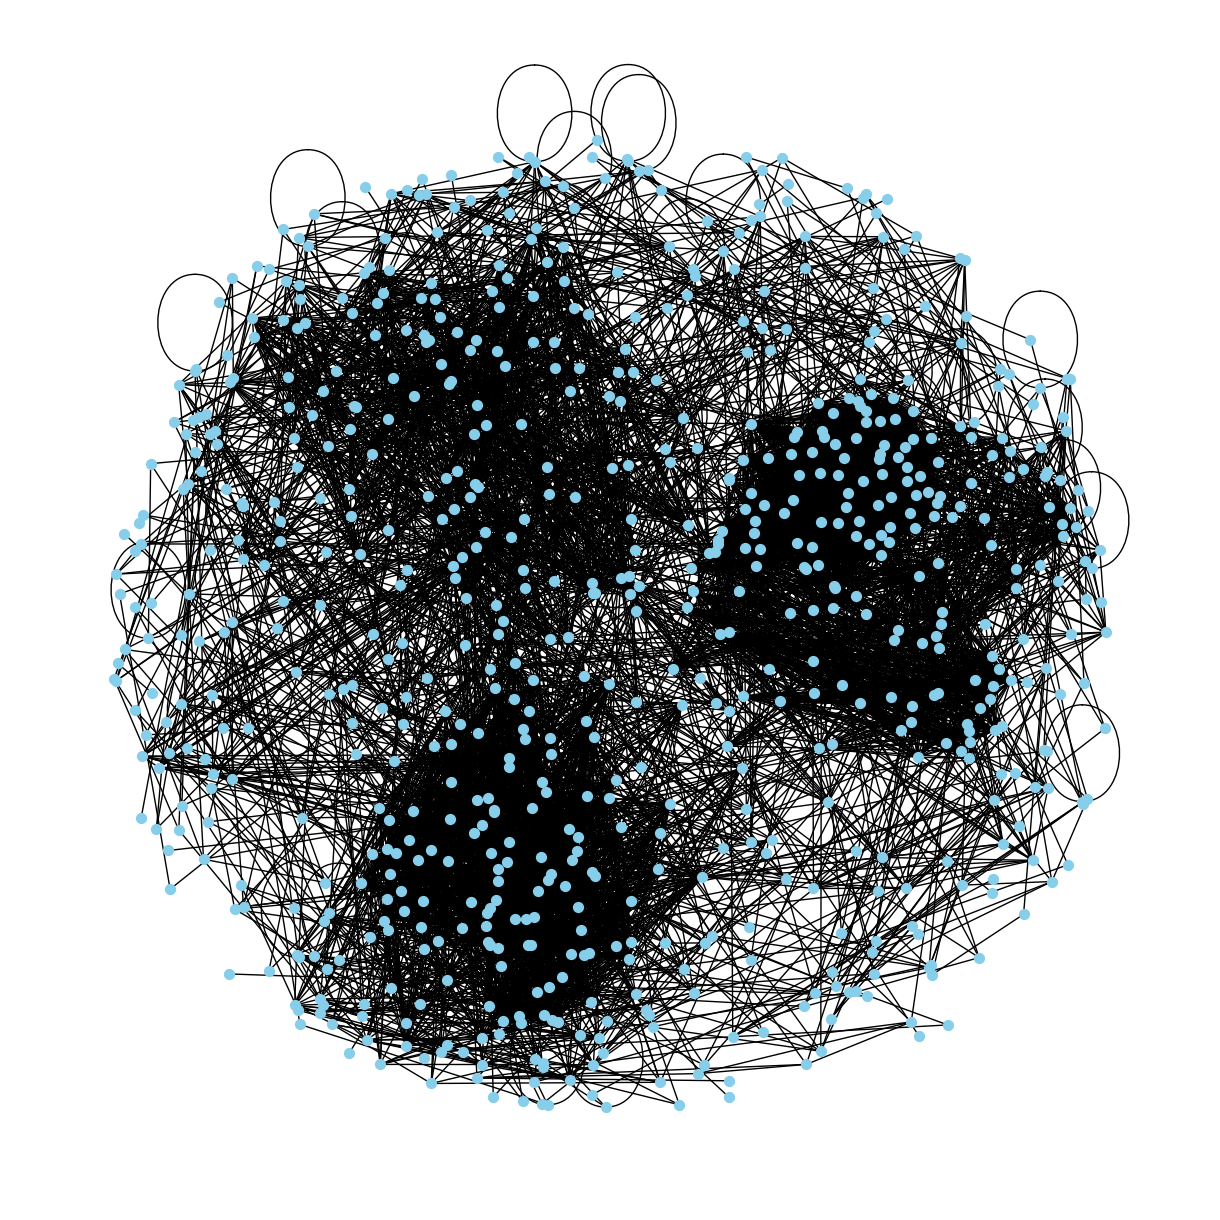

In [6]:
#Aplicando o Spring Layout:
pos = nx.spring_layout(G, k=0.6, iterations=50)

#Visualizando o grafo:
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=False, node_size=50, node_color="skyblue")
plt.show()

## Descrição de cada comunidade da rede:

In [7]:
communities = list(nx.algorithms.community.louvain_communities(G))

# Imprimir comunidades e associar empresas
for i, comm in enumerate(communities):
    comm_str = ',\n'.join(str(node) for node in comm)

    # Encontrar empresas associadas à comunidade
    empresas = jerimum[jerimum['vaga'].isin(comm)]['empresa'].unique()

    # Imprimir informações
    print(f"COMUNIDADE {i+1}:")
    print(f"Empresas associadas: {', '.join(empresas)}")
    print(f"Nós na comunidade:\n{comm_str}\n")

COMUNIDADE 1:
Empresas associadas: ABC FC
Nós na comunidade:
Estágio em suporte, manutenção e redes,
Estágio em desenvolvimento e manutenção de sistemas

COMUNIDADE 2:
Empresas associadas: Activesoft
Nós na comunidade:
Gestor de Suporte,
ESTÁGIO - ENGENHARIA DE PRODUÇÃO, ADMINISTRAÇÃO,
ANALISTA DE DADOS,
Assistente de Controladoria,
Programador Web,
SDR (Sales Development Representative) Natal/RN,
ANALISTA DE PRODUTOS,
Vendedor Interno - SDR,
Desenvolvedor (Migrador),
Desenvolvedor,
ESTÁGIO - ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,
BDR (Business Development Representative),
Migrador,
ESTÁGIO - TECNOLOGIA DA INFORMAÇÃO (BACHARELADO), ENGENHARIA DE SOFTWARE

COMUNIDADE 3:
Empresas associadas: Apetrus Solucões Tecnologicas LTDA
Nós na comunidade:
BACKEND,
Redes Sociais

COMUNIDADE 4:
Empresas associadas: Arena das Dunas
Nós na comunidade:
Desenvolvedor Fullstack (PHP),
Programador Web/Mobile front-end React,
Desenvolvedor Jr./Pleno API Rest,
Estágio em desenvolvimento de API Rest

COMUNIDA

In [8]:
# Seleciona uma comunidade aleatória
random_community = random.choice(communities)

# Cria um subgrafo apenas com os nós da comunidade selecionada
subgraph = G.subgraph(random_community)

# Criar a visualização com Pyvis
net = Network(notebook=True, height="100%", width="100%")

# Definir as opções de física para ajustar a visualização
net.set_options("""
{
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -8000,
      "centralGravity": 0.3,
      "springLength": 150,
      "springConstant": 0.01,
      "damping": 0.09
    }
  }
}
""")

# Adicionar o subgrafo ao Pyvis
net.from_nx(subgraph)

# Gerar e exibir o arquivo HTML
net.show("comunidade_aleatoria.html")

# **Definindo a rede de regimes de trabalho:**

In [9]:
regime_to_vagas = {}

for regime, group in jerimum.groupby('regime_detalhado'):
    vagas = group['vaga'].tolist()
    regime_to_vagas[regime] = vagas

edges = []

for vagas in regime_to_vagas.values():
    for (vaga1, vaga2) in combinations(vagas, 2):
        edges.append((vaga1, vaga2))

edges_jerimum = pd.DataFrame(edges, columns=['Source', 'Target'])
edges_jerimum['Weight'] = 1

G = nx.from_pandas_edgelist(edges_jerimum, 'Source', 'Target', 'Weight')

## Seleção de um valor máximo de nós a serem exibidos:
Para uma melhor visualização, as comunidades do grafo foram abstraídos devido a alta densidade da rede, de modo que a variável "max_nodes" define o limite máximo de nós a serem exibidos na visualização.

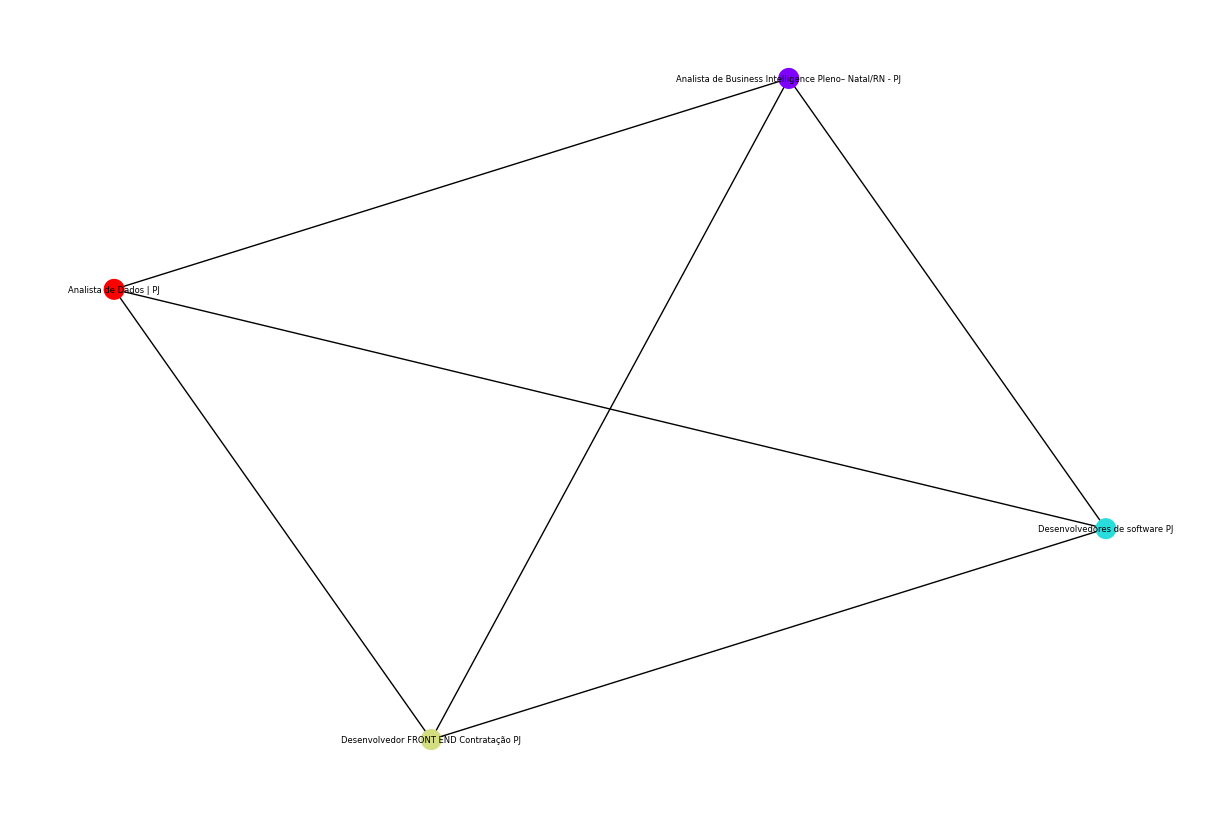

In [10]:
# Supõe-se que o grafo G e as comunidades já foram criados
communities_regime = community.greedy_modularity_communities(G)

# Selecionar uma comunidade aleatória
random_community_index = random.randint(0, len(communities_regime) - 1)
random_community = communities_regime[random_community_index]

# Definir um limite máximo de nós a serem exibidos
max_nodes = 25
if len(random_community) > max_nodes:
    random_community = random.sample(random_community, max_nodes)

# Criar um subgrafo apenas com os nós da comunidade selecionada
subgraph = G.subgraph(random_community)

# Criar uma lista de cores para os nós da comunidade
color_map = plt.cm.rainbow(np.linspace(0, 1, len(random_community)))

# Gerar o layout de força dirigida para o subgrafo
pos = nx.spring_layout(subgraph, k=0.5, iterations=100, seed=42)

# Desenhar o subgrafo
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, node_color=color_map, with_labels=True, node_size=200, edge_color="black", font_size=6)
plt.show()

# **Definindo o grafo da rede de áreas de atuação:**

In [11]:
# Dicionário para armazenar a relação área -> vagas
area_to_vagas = {}

# Corrigir valores NaN nos registros:
jerimum['area_atuacao'] = jerimum['area_atuacao'].apply(lambda x: [] if isinstance(x, float) and pd.isna(x) else x)

# Preencher o dicionário area_to_vagas
for index, row in jerimum.iterrows():
    for area in row['area_atuacao']:
        if area not in area_to_vagas:
            area_to_vagas[area] = []
        area_to_vagas[area].append(row['vaga'])

edges = []

# Criação de arestas com base em áreas de atuação em comum
for area, vagas in area_to_vagas.items():
    # Cria todas as combinações possíveis de pares de vagas
    for (vaga1, vaga2) in combinations(vagas, 2):
        if vaga1 != vaga2:  # Evitar adicionar loops
            edges.append((vaga1, vaga2))

# Converte a lista de arestas para um DataFrame
edges_jerimum = pd.DataFrame(edges, columns=['Source', 'Target'])
edges_jerimum['Weight'] = 1  # Pode ser ajustado conforme necessário

# Cria o grafo usando o DataFrame de arestas
G_area = nx.Graph()
G_area = nx.from_pandas_edgelist(edges_jerimum, 'Source', 'Target', 'Weight')

# **Desenhando a rede de áreas de atuação:**

Para a visualização da rede criada com base nas áreas de atuação, o subgrafo gerado pelo script abaixo usa uma quantidade de nós aleatórios (15, no exemplo) dentre os disponíveis na rede completa, a cada vez que é executado.
Isso foi feito com o objetivo de gerar uma estrutura mais limpa, uma vez que o grafo completo possui muitos nós e densidade relativamente elevada.

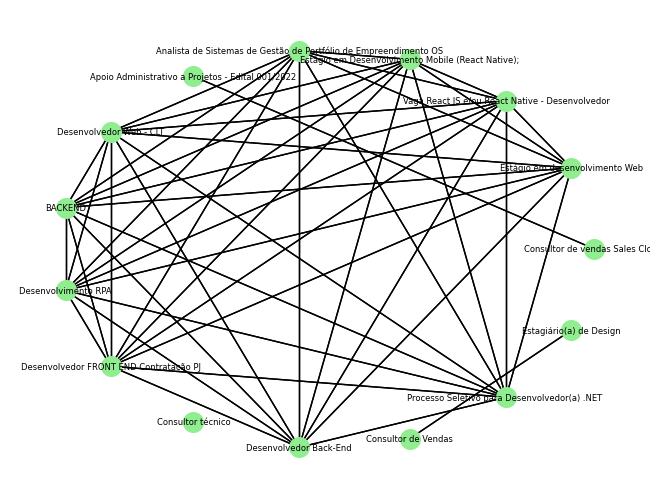

In [12]:
#Para definir a quantidade total de nós da rede: G_area.number_of_nodes
qtd_nos_aleatorios = 15

# Selecionar uma quantidade nós aleatórios
selected_nodes = random.sample(list(G_area.nodes), qtd_nos_aleatorios)

# Criar um subgrafo com esses nós
subgraph = G_area.subgraph(selected_nodes)

# Usar o layout circular para visualização
pos = nx.circular_layout(subgraph)

# Desenhar o subgrafo
nx.draw(subgraph, pos, with_labels=True, font_size=6, node_size=200, node_color="lightgreen")
arc_edges = nx.draw_networkx_edges(subgraph, pos)

plt.show()

## Calculando a densidade do grafo completo e do subgrafo:

In [13]:
print("Densidade Total da rede:", nx.density(G_area))
print("Densidade do subgrafo gerado:", nx.density(subgraph))

print("Assortatividade da rede:", nx.degree_assortativity_coefficient(G_area))
print("Assortatividade do subgrafo:", nx.degree_assortativity_coefficient(subgraph))

Densidade Total da rede: 0.3852002503128911
Densidade do subgrafo gerado: 0.44761904761904764
Assortatividade da rede: 0.6229924306194015
Assortatividade do subgrafo: 0.9999999999999911


## Representação do subgrafo em uma Matriz de adjacência:

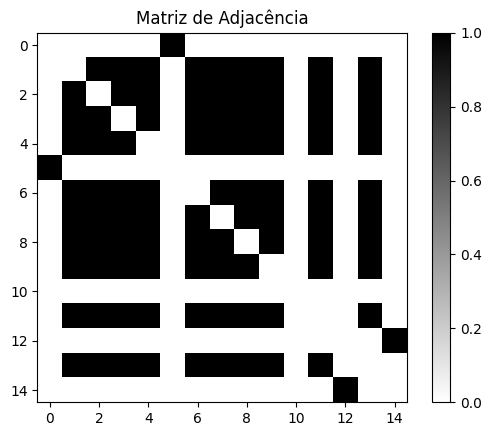

In [14]:
# Gerar a matriz de adjacência do subgrafo
adj_matrix = nx.adjacency_matrix(subgraph).todense()

# Visualizar a matriz de adjacência como uma imagem
plt.imshow(adj_matrix, cmap='binary')
plt.colorbar()
plt.title("Matriz de Adjacência")
plt.show()

## Coeﬁciente de clustering local para nós escolhidos.

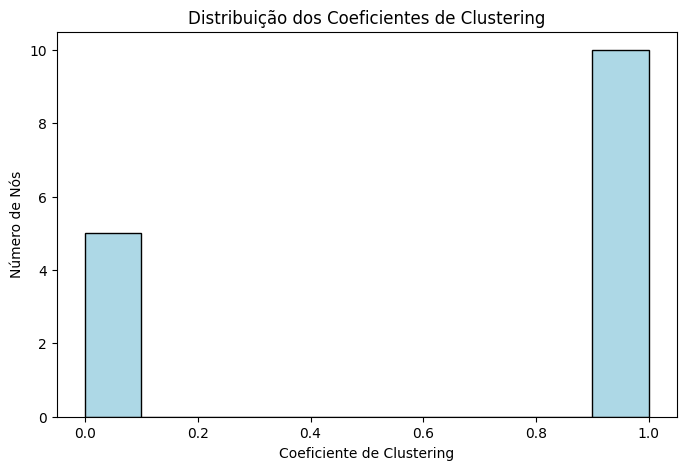

In [15]:
# Calcular o coeficiente de clustering local para os nós escolhidos
clustering_coefficients = nx.clustering(subgraph)

# Extrair os valores dos coeficientes de clustering
coeff_values = list(clustering_coefficients.values())

# Criar o histograma dos coeficientes de clustering
plt.figure(figsize=(8, 5))
plt.hist(coeff_values, bins=10, color="lightblue", edgecolor="black")
plt.xlabel("Coeficiente de Clustering")
plt.ylabel("Número de Nós")
plt.title("Distribuição dos Coeficientes de Clustering")
plt.show()



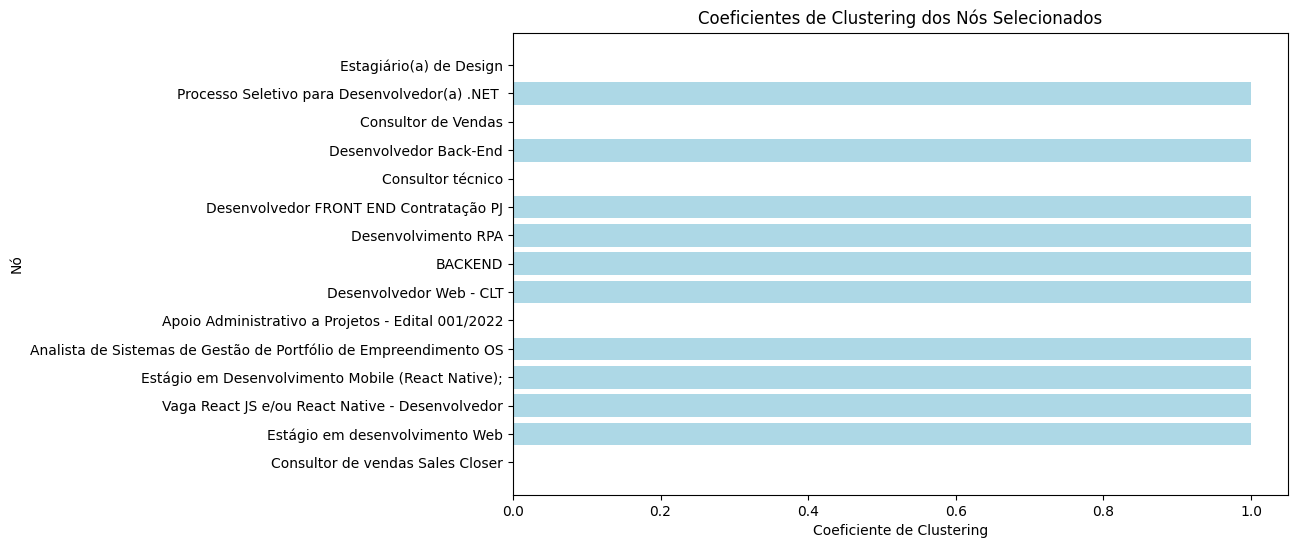

In [16]:
# Criar um subgrafo com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular o coeficiente de clustering local para os nós escolhidos
clustering_coefficients = nx.clustering(subgraph)

# Extrair os nós e seus coeficientes de clustering
nodes = list(clustering_coefficients.keys())
coefficients = list(clustering_coefficients.values())

# Criar um gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(nodes, coefficients, color="lightblue")
plt.ylabel("Nó")
plt.xlabel("Coeficiente de Clustering")
plt.title("Coeficientes de Clustering dos Nós Selecionados")
plt.show()


## Coeﬁciente de clustering global

Coeficiente de Clustering Global: 0.6666666666666666


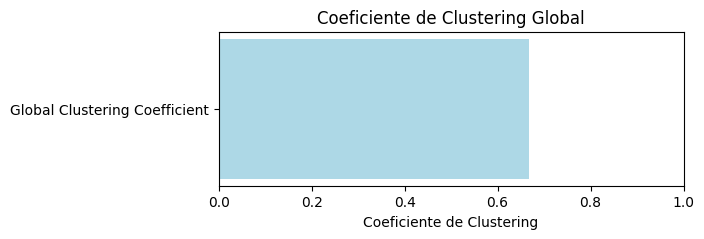

In [17]:
# Criar um subgrafo com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular o coeficiente de clustering global
global_clustering_coefficient = nx.average_clustering(subgraph)

# Exibir o coeficiente de clustering global
print(f"Coeficiente de Clustering Global: {global_clustering_coefficient}")

# Criar um gráfico de barras horizontal para o coeficiente de clustering global
plt.figure(figsize=(6, 2))
plt.barh(['Global Clustering Coefficient'], [global_clustering_coefficient], color="lightblue")
plt.xlabel("Coeficiente de Clustering")
plt.title("Coeficiente de Clustering Global")
plt.xlim(0, 1)  # Define o limite do eixo x para variar de 0 a 1, já que o coeficiente de clustering varia entre esses valores
plt.show()



## Conjunto de componentes conectados dentro do subgrafo:

Componentes Conectados (CCs):
Componente 1: {'Consultor de vendas Sales Closer', 'Apoio Administrativo a Projetos - Edital 001/2022'}
Componente 2: {'Vaga React JS e/ou React Native - Desenvolvedor', 'Estágio em desenvolvimento Web', 'Analista de Sistemas de Gestão de Portfólio de Empreendimento OS', 'Estágio em Desenvolvimento Mobile (React Native);', 'Desenvolvedor Web - CLT', 'Desenvolvimento RPA', 'BACKEND', 'Desenvolvedor FRONT END Contratação PJ', 'Desenvolvedor Back-End', 'Processo Seletivo para Desenvolvedor(a) .NET '}
Componente 3: {'Consultor técnico'}
Componente 4: {'Consultor de Vendas', 'Estagiário(a) de Design'}


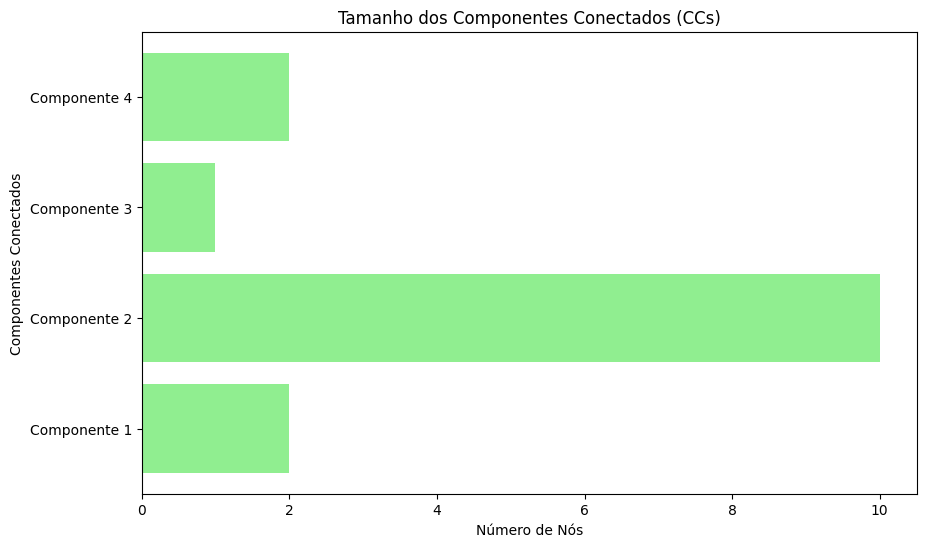

In [18]:
# Garantir que o grafo seja não dirigido
if G_area.is_directed():
    G_area = G_area.to_undirected()

# Criar um subgrafo com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular os Componentes Conectados (CCs)
ccs = list(nx.connected_components(subgraph))

# Exibir os CCs
print(f"Componentes Conectados (CCs):")
for i, cc in enumerate(ccs, start=1):
    print(f"Componente {i}: {cc}")

# Contar o número de nós em cada CC
cc_sizes = [len(cc) for cc in ccs]
cc_labels = [f"Componente {i+1}" for i in range(len(ccs))]

# Criar um gráfico de barras horizontal para o tamanho de cada CC
plt.figure(figsize=(10, 6))
plt.barh(cc_labels, cc_sizes, color="lightgreen")
plt.xlabel("Número de Nós")
plt.ylabel("Componentes Conectados")
plt.title("Tamanho dos Componentes Conectados (CCs)")
plt.show()

# **Visualização para exibir os nós do subgrafo, usando e comparando as seguintes medidas:**

● Eigenvector centrality

● Degree centrality

● Closeness centrality

● Betweenness centrality

Gráfico com Eigenvector centrality

Nós mais importantes de acordo com a Centralidade de Autovetor (Eigenvector Centrality):
Nó: Estágio em desenvolvimento Web, Centralidade de Autovetor: 0.3162277660164235
Nó: Vaga React JS e/ou React Native - Desenvolvedor, Centralidade de Autovetor: 0.3162277660164235
Nó: Estágio em Desenvolvimento Mobile (React Native);, Centralidade de Autovetor: 0.3162277660164235
Nó: Analista de Sistemas de Gestão de Portfólio de Empreendimento OS, Centralidade de Autovetor: 0.3162277660164235
Nó: Desenvolvedor Web - CLT, Centralidade de Autovetor: 0.3162277660164235
Nó: BACKEND, Centralidade de Autovetor: 0.3162277660164235
Nó: Desenvolvimento RPA, Centralidade de Autovetor: 0.3162277660164235
Nó: Desenvolvedor FRONT END Contratação PJ, Centralidade de Autovetor: 0.3162277660164235
Nó: Desenvolvedor Back-End, Centralidade de Autovetor: 0.3162277660164235
Nó: Processo Seletivo para Desenvolvedor(a) .NET , Centralidade de Autovetor: 0.3162277660164235
Nó: Consultor de vendas Sales Closer, Centralid

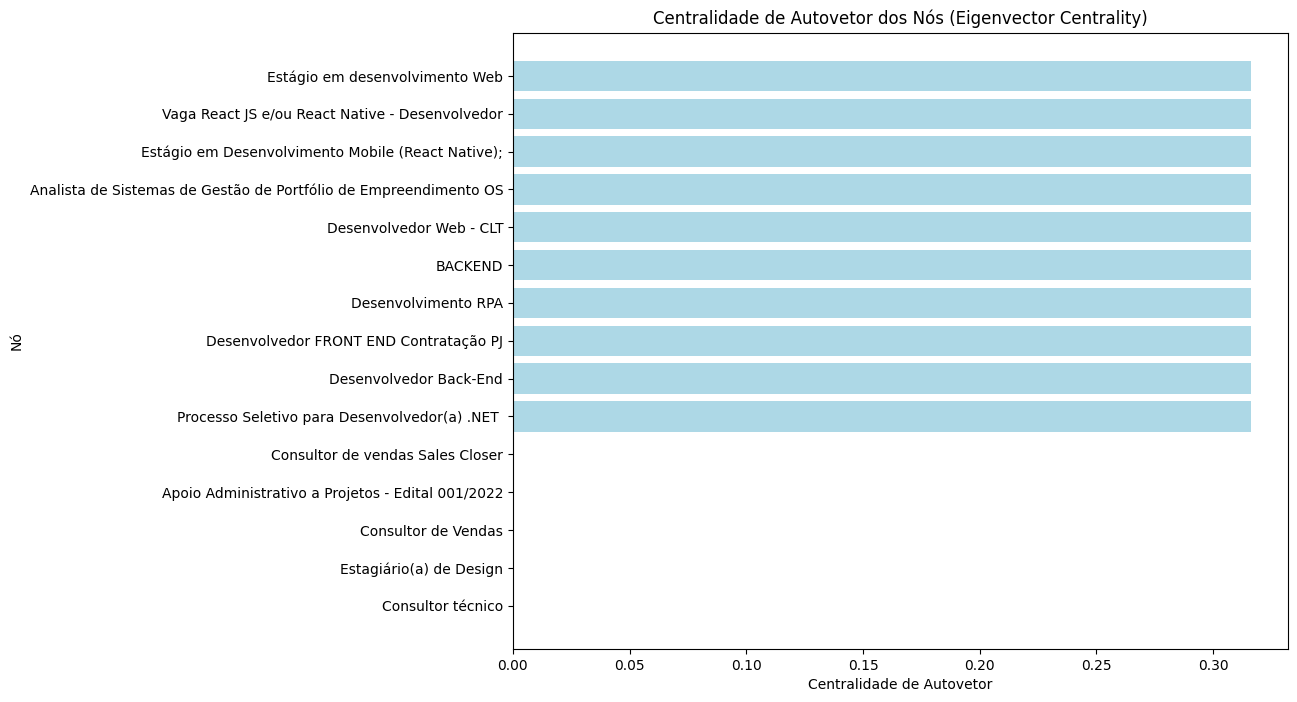

In [19]:
# Garantir que o grafo seja dirigido
if not G_area.is_directed():
    G_area = G_area.to_directed()

# Criar um subgrafo dirigido com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular a centralidade de autovetor (Eigenvector Centrality)
eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)

# Ordenar os nós por centralidade de autovetor em ordem decrescente
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)

# Exibir os nós mais importantes
print("Nós mais importantes de acordo com a Centralidade de Autovetor (Eigenvector Centrality):")
for node, centrality in sorted_eigenvector_centrality:
    print(f"Nó: {node}, Centralidade de Autovetor: {centrality}")

# Extrair os nós e seus valores de centralidade
nodes = [node for node, _ in sorted_eigenvector_centrality]
centralities = [centrality for _, centrality in sorted_eigenvector_centrality]

# Criar um gráfico de barras horizontal para a centralidade de autovetor
plt.figure(figsize=(10, 8))
plt.barh(nodes, centralities, color="lightblue")
plt.xlabel("Centralidade de Autovetor")
plt.ylabel("Nó")
plt.title("Centralidade de Autovetor dos Nós (Eigenvector Centrality)")
plt.gca().invert_yaxis()  # Inverter o eixo y para que o nó com maior centralidade esteja no topo
plt.show()


Grafo com Degree Centrality

Nós mais importantes de acordo com a Centralidade de Grau (Degree Centrality):
Nó: Estágio em desenvolvimento Web, Centralidade de Grau: 1.2857142857142856
Nó: Vaga React JS e/ou React Native - Desenvolvedor, Centralidade de Grau: 1.2857142857142856
Nó: Estágio em Desenvolvimento Mobile (React Native);, Centralidade de Grau: 1.2857142857142856
Nó: Analista de Sistemas de Gestão de Portfólio de Empreendimento OS, Centralidade de Grau: 1.2857142857142856
Nó: Desenvolvedor Web - CLT, Centralidade de Grau: 1.2857142857142856
Nó: BACKEND, Centralidade de Grau: 1.2857142857142856
Nó: Desenvolvimento RPA, Centralidade de Grau: 1.2857142857142856
Nó: Desenvolvedor FRONT END Contratação PJ, Centralidade de Grau: 1.2857142857142856
Nó: Desenvolvedor Back-End, Centralidade de Grau: 1.2857142857142856
Nó: Processo Seletivo para Desenvolvedor(a) .NET , Centralidade de Grau: 1.2857142857142856
Nó: Consultor de vendas Sales Closer, Centralidade de Grau: 0.14285714285714285
Nó: Apoio Administrativo a 

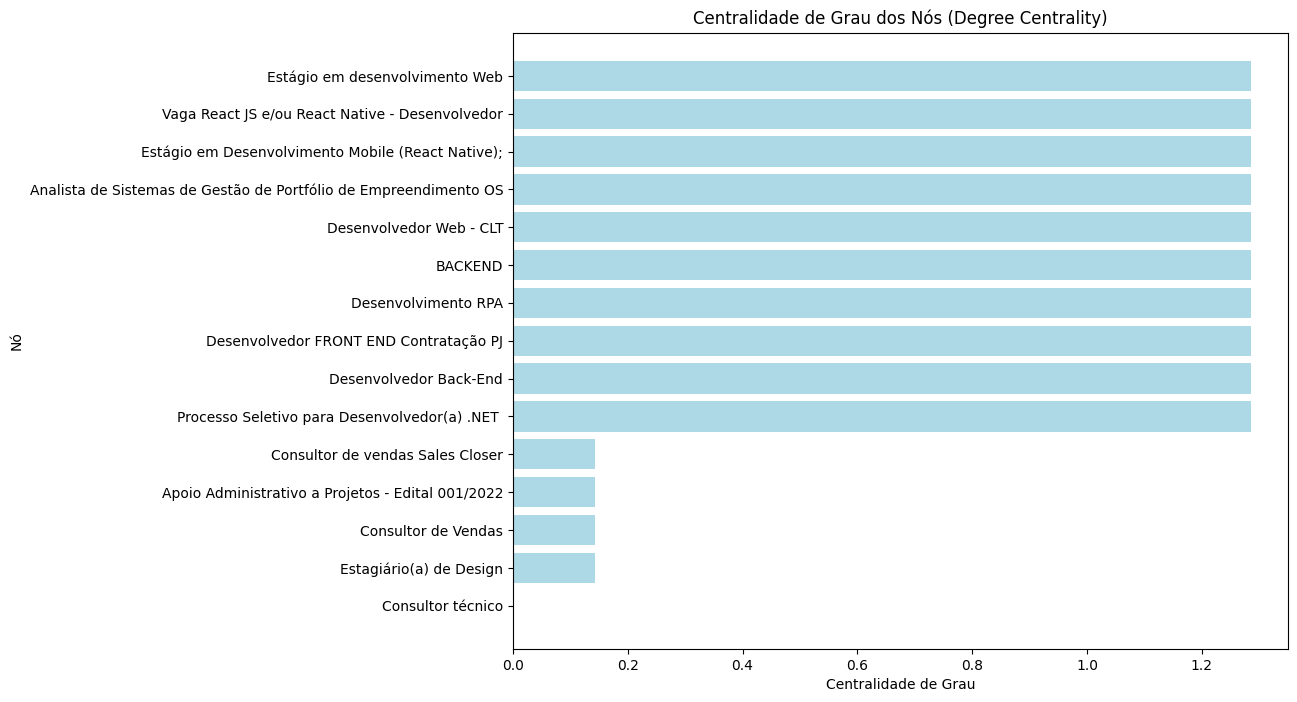

In [20]:
# Garantir que o grafo seja dirigido
if not G_area.is_directed():
    G_area = G_area.to_directed()

# Criar um subgrafo dirigido com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular a centralidade de grau (Degree Centrality)
degree_centrality = nx.degree_centrality(subgraph)

# Ordenar os nós por centralidade de grau em ordem decrescente
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Exibir os nós mais importantes
print("Nós mais importantes de acordo com a Centralidade de Grau (Degree Centrality):")
for node, centrality in sorted_degree_centrality:
    print(f"Nó: {node}, Centralidade de Grau: {centrality}")

# Extrair os nós e seus valores de centralidade
nodes = [node for node, _ in sorted_degree_centrality]
centralities = [centrality for _, centrality in sorted_degree_centrality]

# Criar um gráfico de barras horizontal para a centralidade de grau
plt.figure(figsize=(10, 8))
plt.barh(nodes, centralities, color="lightblue")
plt.xlabel("Centralidade de Grau")
plt.ylabel("Nó")
plt.title("Centralidade de Grau dos Nós (Degree Centrality)")
plt.gca().invert_yaxis()  # Inverter o eixo y para que o nó com maior centralidade esteja no topo
plt.show()


Nós mais importantes de acordo com a Centralidade de Proximidade (Closeness Centrality):
Nó: Estágio em desenvolvimento Web, Centralidade de Proximidade: 0.6428571428571429
Nó: Vaga React JS e/ou React Native - Desenvolvedor, Centralidade de Proximidade: 0.6428571428571429
Nó: Estágio em Desenvolvimento Mobile (React Native);, Centralidade de Proximidade: 0.6428571428571429
Nó: Analista de Sistemas de Gestão de Portfólio de Empreendimento OS, Centralidade de Proximidade: 0.6428571428571429
Nó: Desenvolvedor Web - CLT, Centralidade de Proximidade: 0.6428571428571429
Nó: BACKEND, Centralidade de Proximidade: 0.6428571428571429
Nó: Desenvolvimento RPA, Centralidade de Proximidade: 0.6428571428571429
Nó: Desenvolvedor FRONT END Contratação PJ, Centralidade de Proximidade: 0.6428571428571429
Nó: Desenvolvedor Back-End, Centralidade de Proximidade: 0.6428571428571429
Nó: Processo Seletivo para Desenvolvedor(a) .NET , Centralidade de Proximidade: 0.6428571428571429
Nó: Consultor de vendas Sal

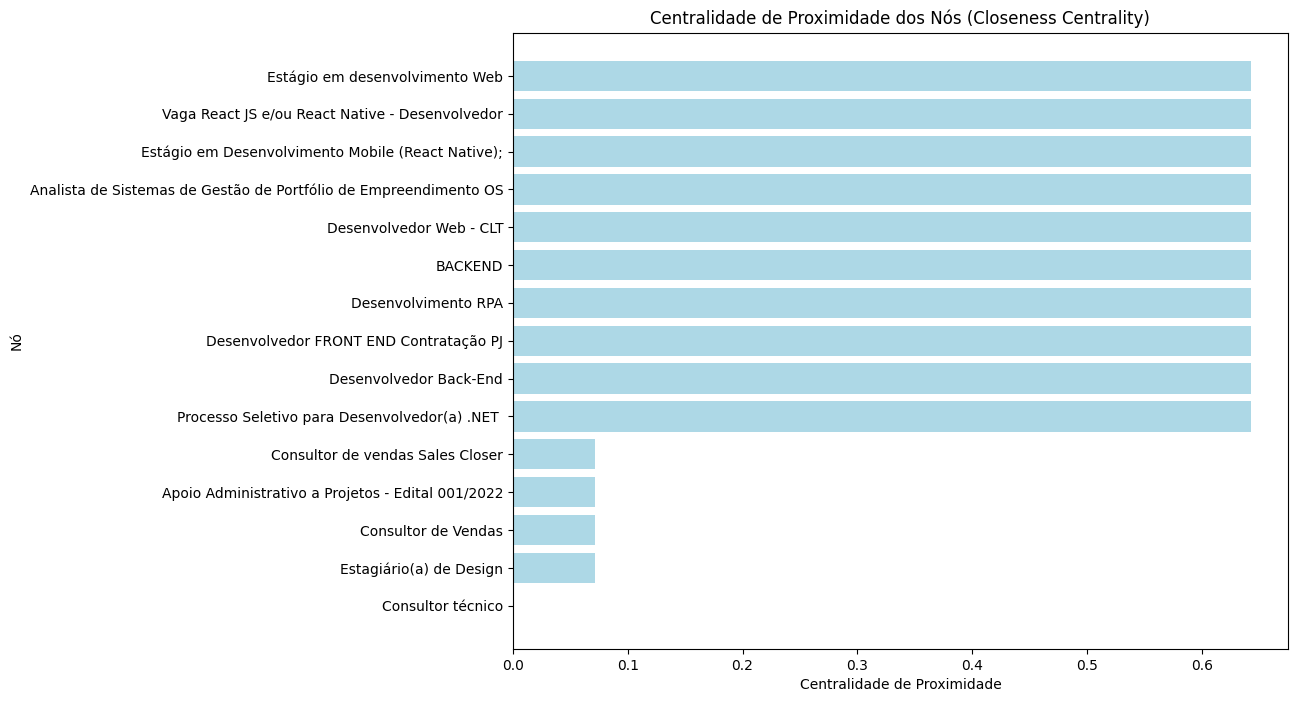

In [21]:
# Garantir que o grafo seja dirigido
if not G_area.is_directed():
    G_area = G_area.to_directed()

# Criar um subgrafo dirigido com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular a centralidade de proximidade (Closeness Centrality)
closeness_centrality = nx.closeness_centrality(subgraph)

# Ordenar os nós por centralidade de proximidade em ordem decrescente
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)

# Exibir os nós mais importantes
print("Nós mais importantes de acordo com a Centralidade de Proximidade (Closeness Centrality):")
for node, centrality in sorted_closeness_centrality:
    print(f"Nó: {node}, Centralidade de Proximidade: {centrality}")

# Extrair os nós e seus valores de centralidade
nodes = [node for node, _ in sorted_closeness_centrality]
centralities = [centrality for _, centrality in sorted_closeness_centrality]

# Criar um gráfico de barras horizontal para a centralidade de proximidade
plt.figure(figsize=(10, 8))
plt.barh(nodes, centralities, color="lightblue")
plt.xlabel("Centralidade de Proximidade")
plt.ylabel("Nó")
plt.title("Centralidade de Proximidade dos Nós (Closeness Centrality)")
plt.gca().invert_yaxis()  # Inverter o eixo y para que o nó com maior centralidade esteja no topo
plt.show()


Gráfico com Betweenness centrality

Nós mais importantes de acordo com a Centralidade de Intermediação (Betweenness Centrality):
Nó: Consultor de vendas Sales Closer, Centralidade de Intermediação: 0.0
Nó: Estágio em desenvolvimento Web, Centralidade de Intermediação: 0.0
Nó: Vaga React JS e/ou React Native - Desenvolvedor, Centralidade de Intermediação: 0.0
Nó: Estágio em Desenvolvimento Mobile (React Native);, Centralidade de Intermediação: 0.0
Nó: Analista de Sistemas de Gestão de Portfólio de Empreendimento OS, Centralidade de Intermediação: 0.0
Nó: Apoio Administrativo a Projetos - Edital 001/2022, Centralidade de Intermediação: 0.0
Nó: Desenvolvedor Web - CLT, Centralidade de Intermediação: 0.0
Nó: BACKEND, Centralidade de Intermediação: 0.0
Nó: Desenvolvimento RPA, Centralidade de Intermediação: 0.0
Nó: Desenvolvedor FRONT END Contratação PJ, Centralidade de Intermediação: 0.0
Nó: Consultor técnico, Centralidade de Intermediação: 0.0
Nó: Desenvolvedor Back-End, Centralidade de Intermediação: 0.0
Nó: Consultor de V

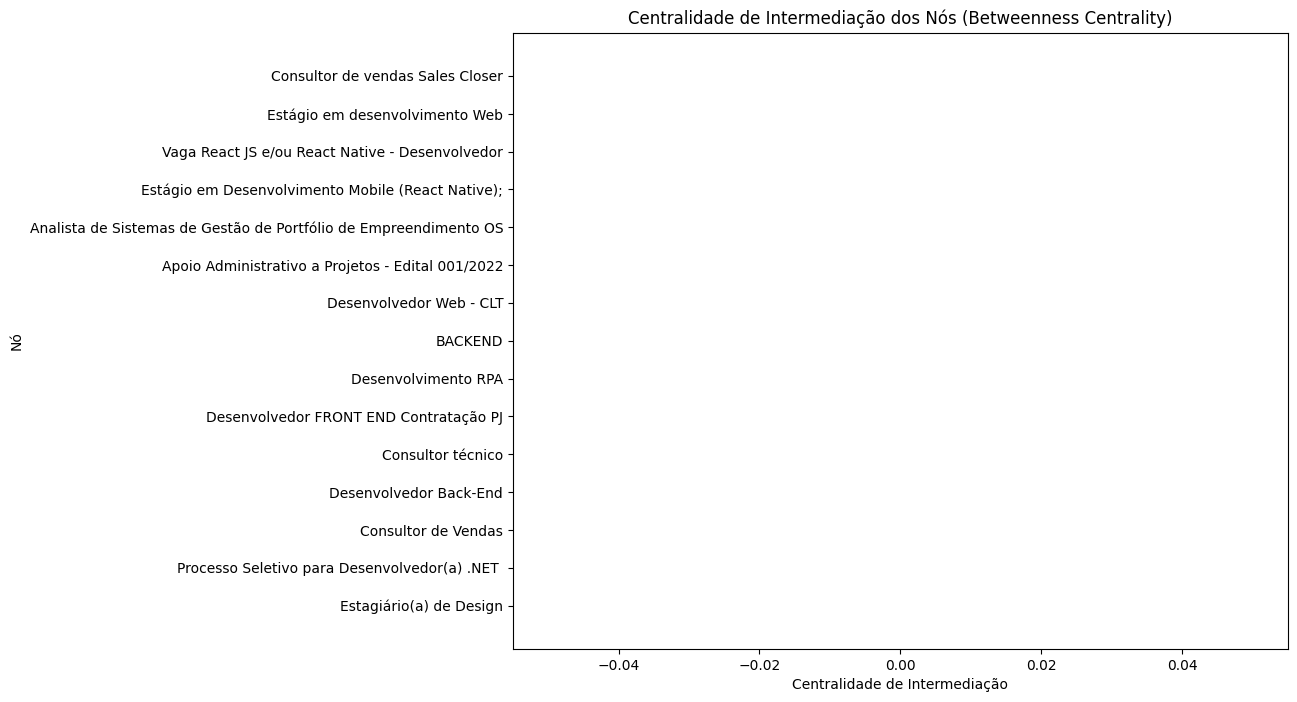

In [22]:
# Garantir que o grafo seja dirigido
if not G_area.is_directed():
    G_area = G_area.to_directed()

# Criar um subgrafo dirigido com esses 15 nós
subgraph = G_area.subgraph(selected_nodes)

# Calcular a centralidade de intermediação (Betweenness Centrality)
betweenness_centrality = nx.betweenness_centrality(subgraph)

# Ordenar os nós por centralidade de intermediação em ordem decrescente
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

# Exibir os nós mais importantes
print("Nós mais importantes de acordo com a Centralidade de Intermediação (Betweenness Centrality):")
for node, centrality in sorted_betweenness_centrality:
    print(f"Nó: {node}, Centralidade de Intermediação: {centrality}")

# Extrair os nós e seus valores de centralidade
nodes = [node for node, _ in sorted_betweenness_centrality]
centralities = [centrality for _, centrality in sorted_betweenness_centrality]

# Criar um gráfico de barras horizontal para a centralidade de intermediação
plt.figure(figsize=(10, 8))
plt.barh(nodes, centralities, color="lightblue")
plt.xlabel("Centralidade de Intermediação")
plt.ylabel("Nó")
plt.title("Centralidade de Intermediação dos Nós (Betweenness Centrality)")
plt.gca().invert_yaxis()  # Inverter o eixo y para que o nó com maior centralidade esteja no topo
plt.show()


In [23]:
# Função para gerar visualização do grafo com pyvis
def visualize_graph(G):
    # Criar o grafo pyvis
    net = Network(notebook=False, height="100%", width="100%")

    # Adicionar nós e arestas ao pyvis
    net.from_nx(G)

    # Definir opções para melhorar a visualização
    net.set_options("""
    var options = {
      "physics": {
        "enabled": true,
        "barnesHut": {
          "gravitationalConstant": -5000,
          "centralGravity": 0.3,
          "springLength": 200,
          "springConstant": 0.04
        },
        "minVelocity": 0.75
      },
      "nodes": {
        "size": 15,
        "color": {
          "background": "skyblue",
          "border": "black"
        }
      },
      "edges": {
        "color": "gray",
        "smooth": {
          "enabled": true,
          "type": "continuous"
        }
      }
    }
    """)

    return net

In [24]:
# Configurar a aplicação Streamlit
def main():
    st.title("Visualização de Grafo com Streamlit e Pyvis")

    # Visualizar o grafo
    net_pyvis = visualize_graph(subgraph)

    # Mostrar o grafo no Streamlit
    net_pyvis.show("graph.html")

    # Exibir o HTML no Streamlit
    st.components.v1.html(open("graph.html", 'r').read(), height=700)

if __name__ == "__main__":
    main()

2024-08-23 13:51:45.948 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
